In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project 1

/content/drive/MyDrive/project 1


In [3]:
%pwd

'/content/drive/MyDrive/project 1'

In [4]:
%pip install import-ipynb
%pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.6 MB/s eta 0:00:00


### Task 2

#### 1. Basic Concepts


1.   For the PAD method, the key knowledge gap addressed was the issue of misaligned information during the dataset distillation process, where existing methods struggled with effectively aligning the extracted information from the original data and embedding it into the synthetic dataset. Prior methods often introduced irrelevant or low-level information, leading to inefficiencies in dataset distillation. PAD proposes a solution by pruning samples based on the difficulty and using only deep layers of the agent model for distillation, ensuring better alignment.
2. There are two novelty compared to the prior methods:
  *   Filtering based on sample difficulty: Selecting easy or hard samples based on the Information Per Class (IPC) ratio to better match the synthetic dataset to the needs of the model.
  *   Using only deep layers for the distillation process, which focuses on high-level semantic information and avoids redundant low-level details. ∇

  This approach allows PAD to achieve state-of-the-art (SOTA) performance and address the misalignment issue more effectively than previous methods.
3. There are two main steps in PAD:
  * Filtering Information Extraction: Use a difficulty scoring method (like EL2N score) to rank samples based on their difficulty. For low IPCs, the focus is on using easier samples, while high IPCs gradually incorporate harder samples.A scheduler gradually incorporates harder samples as training progresses, balancing information across stages.
  * Filtering Information Embedding: Instead of using all parameters from the agent model, PAD discards shallow-layer parameters and focuses on deep layers to embed higher-level features into the synthetic dataset, yielding high-quality synthetic data aligned with the target distribution.
4.∇
  * Advantages:
    * PAD improves alignment between the learning paths of models trained on synthetic and real data, leading to better performance.
    * The sample selection mechanism makes it more effective in retaining critical information, especially with varying levels of difficulty.
    * It performs well across various datasets like CIFAR and Tiny ImageNet, showcasing adaptability.
    
  * Disadvantages:
    * The method’s effectiveness depends on the accuracy of the difficulty scoring. If the scoring method is not reliable, the selection of samples may be suboptimal.
    * It may be computationally intensive to record trajectories and filter samples, especially with deep layers.
    * Designed mainly for CNNs, PAD might not generalize as effectively to non-CNN models.

  * Yes, the PAD method can concretely distill the original datasets. Its approach of aligning the difficulty of the extracted information with the compression ratio allows for the creation of synthetic datasets that retain the critical features of the original data. By selectively using only deep-layer parameters during the embedding stage, PAD ensures that the distilled datasets capture high-level, semantic information rather than low-level, redundant details. This leads to a more compact yet representative dataset that can achieve similar performance to models trained on the original data​.

  * PAD is capable of analyzing and inspecting large-scale datasets like ImageNet, but with certain considerations. Its filtering strategy, which prioritizes high-level semantic information during the distillation process, makes it suitable for handling the complexity of larger datasets. This is demonstrated through its performance on smaller versions like Tiny ImageNet, where it effectively manages the challenge of compressing high-resolution data.  
  However, while PAD's methods of information extraction and embedding show potential for scalability, the computational demands may increase significantly when applied to a full-scale dataset like ImageNet. This means that additional optimizations may be needed to manage memory and training time efficiently. In summary, PAD can handle large-scale datasets, but practical considerations like computational resources and fine-tuning the data scheduler will play a critical role in its effectiveness​




##### steps


*  resize the imgs to 32 * 32
*  start with IPC  = [10, 25, 50]
*  lr = 0.01 for student



#### 2. Data Distillation Learning - MHIST


##### a) Train model with origianl dataset


In [5]:
import random
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

In [6]:
import import_ipynb
from utils import get_network, get_time

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Expected dataset size: {len(train_dataset)}")

Expected dataset size: 2175


In [ ]:
model_path = 'models/mhist_original.pth'
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
model.load_state_dict(torch.load(model_path))

<ipython-input-9-bfca554a1187>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 81.06%


In [ ]:
def calculate_el2n_scores(model, dataloader, device):
    model.eval()
    el2n_scores = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            el2n = (probs - F.one_hot(labels, num_classes=probs.size(1))).pow(2).sum(dim=1)
            batch_start = batch_idx * dataloader.batch_size
            for idx, score in enumerate(el2n):
                dataset_idx = batch_start + idx
                el2n_scores.append((dataset_idx, score.item()))

    return el2n_scores

el2n_scores = calculate_el2n_scores(model, train_loader, device)
el2n_scores_sorted = sorted(el2n_scores, key=lambda x: x[1])
sorted_indices = [idx for idx, _ in el2n_scores_sorted]

###### train teacher model


In [ ]:
train_epochs = 20
add_end_epoch = 7
rm_epoch_first = 12
rm_epoch_second = 17

initial_ratio = 0.75
rm_easy_ratio_first = 0.5
rm_easy_ratio_second = 0.3

batch_size = 64


In [ ]:
teacher_net = get_network(model='ConvNetD7', channel=3,
                          num_classes=2, im_size=(224, 224))
optimizer = SGD(teacher_net.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def linear_scheduler(t, a, b):
    return min(1, 1.0 * a + (1 - a) * 1.0 * t / b)

In [ ]:
def get_training_indices(sorted_indices, epoch, add_end_epoch, rm_epoch_first, rm_epoch_second,
                         initial_ratio=0.75, rm_easy_ratio_first=0.5, rm_easy_ratio_second=0.3):

    if epoch <= add_end_epoch:
      current_ratio = linear_scheduler(epoch, initial_ratio, add_end_epoch)
      num_samples = int(current_ratio * len(sorted_indices))
      selected_indices = sorted_indices[:num_samples]
    elif add_end_epoch < epoch <= rm_epoch_first:
      current_ratio = 1.0
      num_samples = int(current_ratio * len(sorted_indices))
      selected_indices = sorted_indices[:num_samples]
    elif rm_epoch_first < epoch <= rm_epoch_second:
      current_ratio = rm_easy_ratio_first
      num_samples = int(current_ratio * len(sorted_indices))
      selected_indices = sorted_indices[-num_samples:]
    else:
      current_ratio = rm_easy_ratio_second
      num_samples = int(current_ratio * len(sorted_indices))
      selected_indices = sorted_indices[-num_samples:]

    return selected_indices


In [ ]:
import copy

def training_teacher_model(model, optimizer, criterion):
    torch.cuda.empty_cache()

    teacher_trajectory = []
    teacher_trajectory.append(copy.deepcopy(model.cpu().state_dict()))
    model.to(device)
    for epoch in range(train_epochs):
      selected_indices = get_training_indices(sorted_indices, epoch,
                                              add_end_epoch, rm_epoch_first,
                                              rm_epoch_second)
      subset_dataset = Subset(train_dataset, selected_indices)
      sub_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

      model.train()

      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in sub_train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

          torch.cuda.empty_cache()
      teacher_trajectory.append(copy.deepcopy(model.cpu().state_dict()))
      model.to(device)

      train_accuracy = 100. * correct / total
      print(f"Epoch [{epoch+1}/{train_epochs}], Loss: {running_loss / len(train_loader.dataset)}, Accuracy: {train_accuracy:.2f}%")

    return teacher_trajectory

In [ ]:
teacher_trajectory = training_teacher_model(teacher_net, optimizer, criterion)

Epoch [1/20], Loss: 0.3610594401414367, Accuracy: 80.69%
Epoch [2/20], Loss: 0.3118145909254578, Accuracy: 83.26%
Epoch [3/20], Loss: 0.2921997201579741, Accuracy: 84.94%
Epoch [4/20], Loss: 0.25701597476827687, Accuracy: 88.04%
Epoch [5/20], Loss: 0.2899220265602243, Accuracy: 86.66%
Epoch [6/20], Loss: 0.2986809537739589, Accuracy: 86.43%
Epoch [7/20], Loss: 0.2977433186563952, Accuracy: 87.12%
Epoch [8/20], Loss: 0.30343545338203165, Accuracy: 88.37%
Epoch [9/20], Loss: 0.2468482354043544, Accuracy: 91.13%
Epoch [10/20], Loss: 0.2044152043605673, Accuracy: 92.46%
Epoch [11/20], Loss: 0.17140108992998626, Accuracy: 93.47%
Epoch [12/20], Loss: 0.14511251626686117, Accuracy: 95.17%
Epoch [13/20], Loss: 0.09056890922716294, Accuracy: 97.10%
Epoch [14/20], Loss: 0.05294041849415878, Accuracy: 97.79%
Epoch [15/20], Loss: 0.03196509941042155, Accuracy: 98.90%
Epoch [16/20], Loss: 0.017904379162295113, Accuracy: 99.54%
Epoch [17/20], Loss: 0.02025673044824052, Accuracy: 99.36%
Epoch [18/20]

In [ ]:
model_path = 'models/teacher_net.pth'
torch.save(teacher_net.cpu().state_dict(), model_path)

trajectory_path = 'task2_results/teacher_trajectory.pth'
torch.save(teacher_trajectory, trajectory_path)

In [ ]:
model_path = 'models/teacher_net.pth'
teacher_net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
teacher_net.load_state_dict(torch.load(model_path, map_location=device))


<ipython-input-11-7231acc5e769>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_net.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.long()
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
evaluate_model(teacher_net, test_loader)

Test Accuracy: 79.22%


In [ ]:
from ptflops import get_model_complexity_info

total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(teacher_net, (3, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

##### b) Learn the synthetic dataset with prioritize alignment


In [16]:
# real dataset loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=64, shuffle=True)

In [17]:
trajectory_path = 'task2_results/teacher_trajectory.pth'
teacher_trajectory = torch.load(trajectory_path, map_location=device)

<ipython-input-17-ed6fbaca4762>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_trajectory = torch.load(trajectory_path, map_location=device)


In [ ]:
num_classes = 2
num_images_per_class = 50
img_size = (3, 224, 224)

def generate_synthetic_dataset(real_dataset, num_classes=2, images_per_class=50, K=200, eta_s=0.1,
                               zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):

        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            img_real = real_dataset[i][0].to(device)

            synthetic_versions = []
            for _ in range(K):
                synthetic_image = img_real.clone().detach().requires_grad_(True)
                synthetic_versions.append(synthetic_image)

            for synthetic_image in synthetic_versions:
                optimizer_condensed = optim.SGD([synthetic_image], lr=eta_s)

                for _ in range(zeta_s):
                    optimizer_condensed.zero_grad()
                    loss = torch.nn.functional.mse_loss(synthetic_image, img_real)
                    loss.backward()
                    optimizer_condensed.step()

            final_synthetic_image = torch.mean(torch.stack(synthetic_versions), dim=0).detach()

            synthetic_images.append(final_synthetic_image)
            synthetic_labels.append(class_id)

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

In [ ]:
def match_with_deep_layers_only(agent_model, target_params, synthetic_data, match_layers_threshold=0.5):
    model_params = list(agent_model.parameters())

    num_layers = len(model_params)
    num_shallow_layers = int(match_layers_threshold * num_layers)

    deep_layers_params = model_params[num_shallow_layers:]

    target_params_list = [param.detach().to(deep_layers_params[0].device)
                          for _, param in target_params.items()][num_shallow_layers:]

    loss = sum(F.mse_loss(param, target_param)
               for param, target_param in zip(deep_layers_params, target_params_list))

    return loss

In [ ]:
def train_synthetic_images_with_trajectory(
    agent_model,
    teacher_trajectory,
    synthetic_data,
    labels_syn,
    num_iterations=10,
    eta_s=0.1,
    match_layers_threshold=0.5,
    device='cuda'
):
    synthetic_data.requires_grad_(True)
    optimizer_img = optim.SGD([synthetic_data], lr=eta_s)
    model_params = list(agent_model.parameters())

    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        start_idx = torch.randint(0, len(teacher_trajectory) - 1, (1,)).item()
        target_params = teacher_trajectory[start_idx + 1]  # Next state in the trajectory

        agent_model.train()
        for _ in range(5):
            output = agent_model(synthetic_data)
            loss = F.cross_entropy(output, labels_syn)
            optimizer_img.zero_grad()
            loss.backward()
            optimizer_img.step()

        match_loss = match_with_deep_layers_only(agent_model, target_params, synthetic_data, match_layers_threshold)

        optimizer_img.zero_grad()
        match_loss.backward()
        optimizer_img.step()

        print(f"Iteration {iteration + 1}, Match Loss: {match_loss.item():.4f}")

    print("Synthetic image generation with deep-layer alignment completed.")
    return synthetic_data, labels_syn

In [ ]:
img_syn, labels_syn = generate_synthetic_dataset(real_dataset)

In [ ]:
model_path = 'models/teacher_net.pth'
temp_net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
temp_net.load_state_dict(torch.load(model_path, map_location=device))

synthetic_data, labels_syn = train_synthetic_images_with_trajectory(temp_net,
                                                        teacher_trajectory,
                                                        img_syn,
                                                        labels_syn)

<ipython-input-30-408686875f37>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  temp_net.load_state_dict(torch.load(model_path, map_location=device))


Iteration 1/10
Iteration 1, Match Loss: 0.0000
Iteration 2/10
Iteration 2, Match Loss: 0.0004
Iteration 3/10
Iteration 3, Match Loss: 0.0062
Iteration 4/10
Iteration 4, Match Loss: 0.0035
Iteration 5/10
Iteration 5, Match Loss: 0.0054
Iteration 6/10
Iteration 6, Match Loss: 0.0001
Iteration 7/10
Iteration 7, Match Loss: 0.0001
Iteration 8/10
Iteration 8, Match Loss: 0.0035
Iteration 9/10
Iteration 9, Match Loss: 0.0047
Iteration 10/10
Iteration 10, Match Loss: 0.0002
Synthetic image generation with deep-layer alignment completed.


In [ ]:
def save_results(img_syn, labels_syn, noise_type=''):
    save_path = f"mhist_result/PAD_{noise_type}_synthetic_dataset.pt"

    torch.save({'images': img_syn, 'labels': labels_syn}, save_path)

    print(f"Synthetic dataset saved to {save_path}")

In [ ]:
save_results(synthetic_data, labels_syn)

Synthetic dataset saved to mhist_result/PAD__synthetic_dataset.pt


##### 2c) Visualize the condensed images per class

In [18]:
import torch
import os
import matplotlib.pyplot as plt

def display_image_grid(img_syn, labels_syn, noise_type):
    # Create directory to save grid images
    save_dir = f"task2_results/PAD_{noise_type}_grid"
    os.makedirs(save_dir, exist_ok=True)

    num_samples_per_class = 50

    class_dict = {}

    for img, label in zip(img_syn, labels_syn):
        label = label.item()
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)

    for class_label, images in class_dict.items():
        selected_images = images[:num_samples_per_class]

        fig, axs = plt.subplots(5, 10, figsize=(15, 7))
        fig.suptitle(f"Class {class_label} - {noise_type}", fontsize=16)
        fig.patch.set_facecolor('white')


        for idx, img in enumerate(selected_images):
            img_np = img.permute(1, 2, 0).detach().cpu().numpy()
            img_np = img_np - img_np.min()  # Normalize to 0
            img_np = img_np / img_np.max()  # Normalize to 1
            axs[idx // 10, idx % 10].imshow(img_np)
            axs[idx // 10, idx % 10].axis('off')
            axs[idx // 10, idx % 10].set_facecolor('white')

        plt.show()

        grid_save_path = os.path.join(save_dir, f"class_{class_label}_grid.png")
        fig.savefig(grid_save_path, facecolor='white')
        plt.close()

    print(f"Image grids saved to {save_dir}")

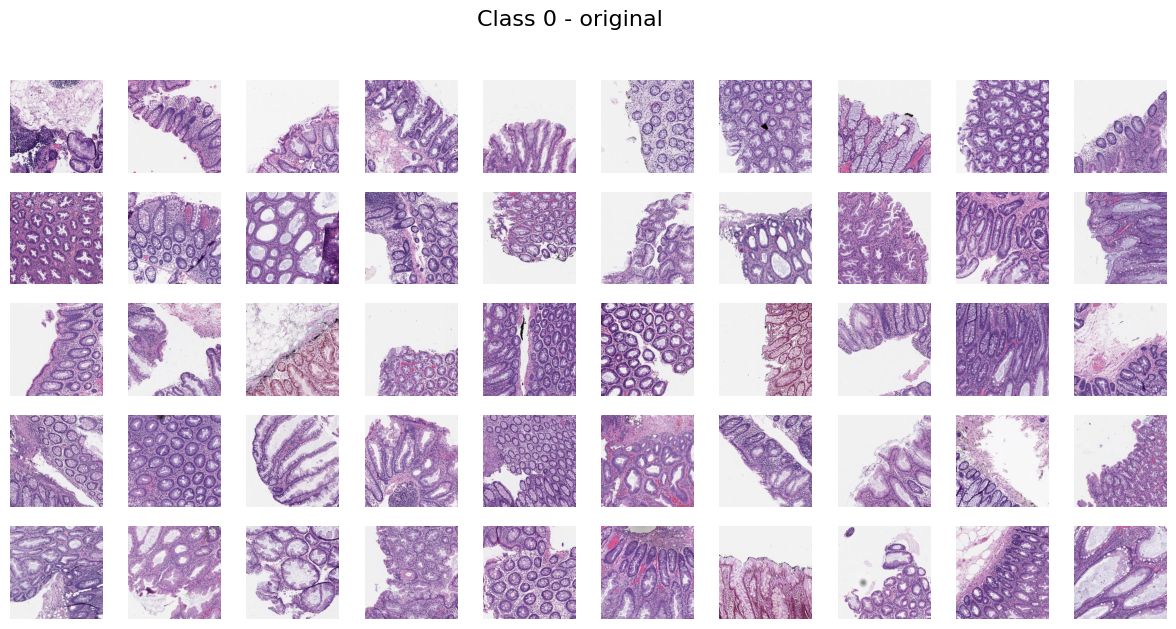

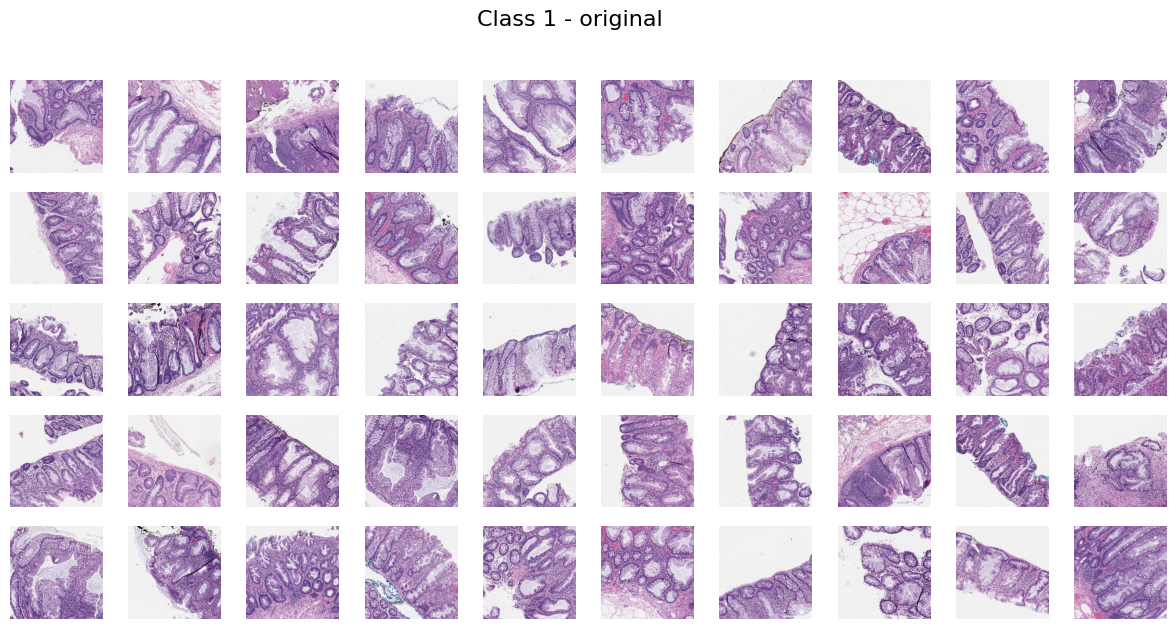

Image grids saved to task2_results/PAD_original_grid


In [20]:
display_image_grid(synthetic_data, labels_syn, noise_type='original')

#### random noise

In [ ]:
# set up the synthetic dataset
import random

num_classes = 2
num_images_per_class = 50
img_size = (3, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            noise = torch.rand(size=real_dataset[i][0].shape, requires_grad=True).to(device)
            synthetic_image = real_dataset[i][0] + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])


    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

In [ ]:
random_img_syn, random_labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)


In [ ]:
model_path = 'models/teacher_net.pth'
trajectory_path = 'task2_results/teacher_trajectory.pth'

teachet_trajectory = torch.load(trajectory_path, map_location=device)
temp_net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
temp_net.load_state_dict(torch.load(model_path, map_location=device))


random_synthetic_data, random_labels_syn = train_synthetic_images_with_trajectory(temp_net,
                                                        teacher_trajectory,
                                                        random_img_syn,
                                                        random_labels_syn)
save_results(random_synthetic_data, random_labels_syn, 'Random')

<ipython-input-37-e6d7785f99a7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teachet_trajectory = torch.load(trajectory_path, map_location=device)
<ipython-input-37-e6d7

Iteration 1/10
Iteration 1, Match Loss: 0.0162
Iteration 2/10
Iteration 2, Match Loss: 0.0081
Iteration 3/10
Iteration 3, Match Loss: 0.0000
Iteration 4/10
Iteration 4, Match Loss: 0.0081
Iteration 5/10
Iteration 5, Match Loss: 0.0000
Iteration 6/10
Iteration 6, Match Loss: 0.0012
Iteration 7/10
Iteration 7, Match Loss: 0.0081
Iteration 8/10
Iteration 8, Match Loss: 0.0047
Iteration 9/10
Iteration 9, Match Loss: 0.0000
Iteration 10/10
Iteration 10, Match Loss: 0.0000
Synthetic image generation with deep-layer alignment completed.
Synthetic dataset saved to mhist_result/PAD_Random_synthetic_dataset.pt


<ipython-input-22-44f46212ca39>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')


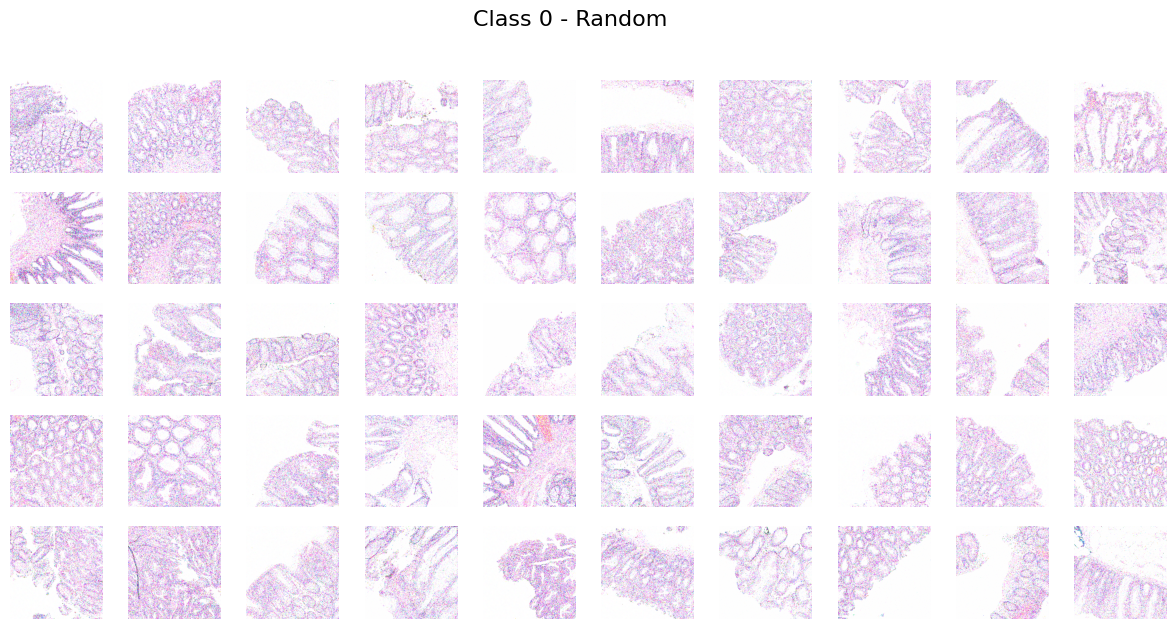

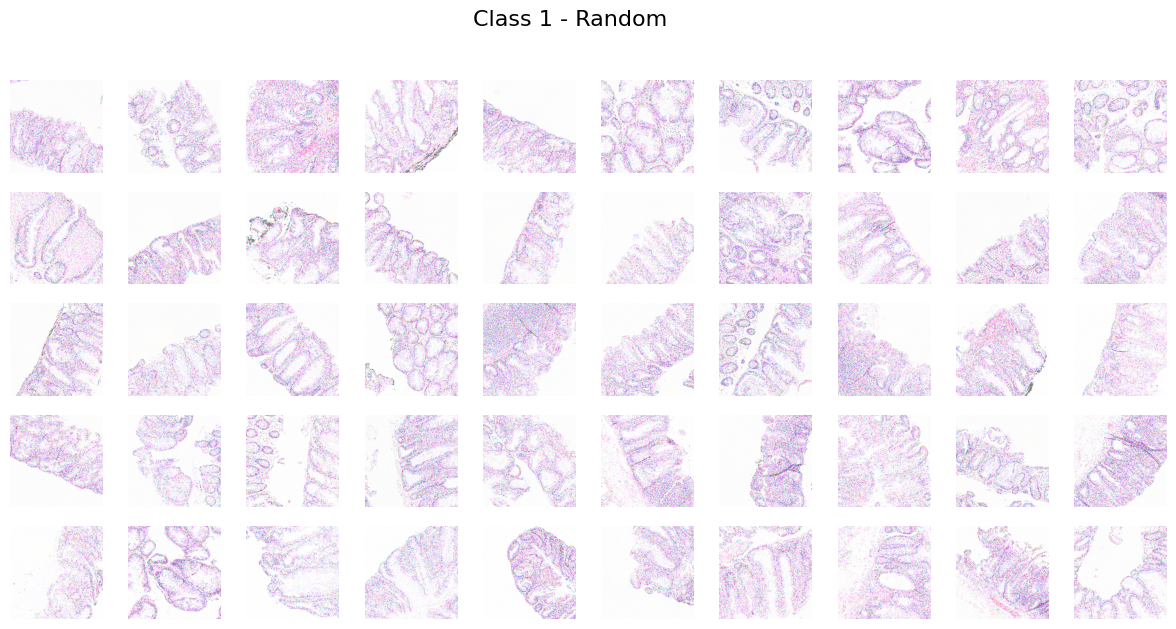

Image grids saved to task2_results/PAD_Random_grid


In [22]:
img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Random')

In [ ]:
# 2d
def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            noise = torch.normal(mean=0, std=noise_std, size=real_dataset[i][0].size())
            synthetic_image = real_dataset[i][0] + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])


    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn


In [ ]:
model_path = 'models/teacher_net.pth'
trajectory_path = 'task2_results/teacher_trajectory.pth'

teachet_trajectory = torch.load(trajectory_path, map_location=device)
temp_net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
temp_net.load_state_dict(torch.load(model_path, map_location=device))

gaussian_img_syn, gaussian_labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

temp_net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
temp_net.load_state_dict(torch.load(model_path, map_location=device))

gaussian_synthetic_data, gaussian_labels_syn = train_synthetic_images_with_trajectory(temp_net,
                                                        teacher_trajectory,
                                                        gaussian_img_syn,
                                                        gaussian_labels_syn)
save_results(gaussian_synthetic_data, gaussian_labels_syn, 'Gaussian')


<ipython-input-40-5c7404200530>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teachet_trajectory = torch.load(trajectory_path, map_location=device)
<ipython-input-40-5c74

Iteration 1/10
Iteration 1, Match Loss: 0.0025
Iteration 2/10
Iteration 2, Match Loss: 0.0162
Iteration 3/10
Iteration 3, Match Loss: 0.0047
Iteration 4/10
Iteration 4, Match Loss: 0.0081
Iteration 5/10
Iteration 5, Match Loss: 0.0071
Iteration 6/10
Iteration 6, Match Loss: 0.0062
Iteration 7/10
Iteration 7, Match Loss: 0.0000
Iteration 8/10
Iteration 8, Match Loss: 0.0018
Iteration 9/10
Iteration 9, Match Loss: 0.0062
Iteration 10/10
Iteration 10, Match Loss: 0.0035
Synthetic image generation with deep-layer alignment completed.
Synthetic dataset saved to mhist_result/PAD_Gaussian_synthetic_dataset.pt


<ipython-input-23-ca2d4d763d41>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')


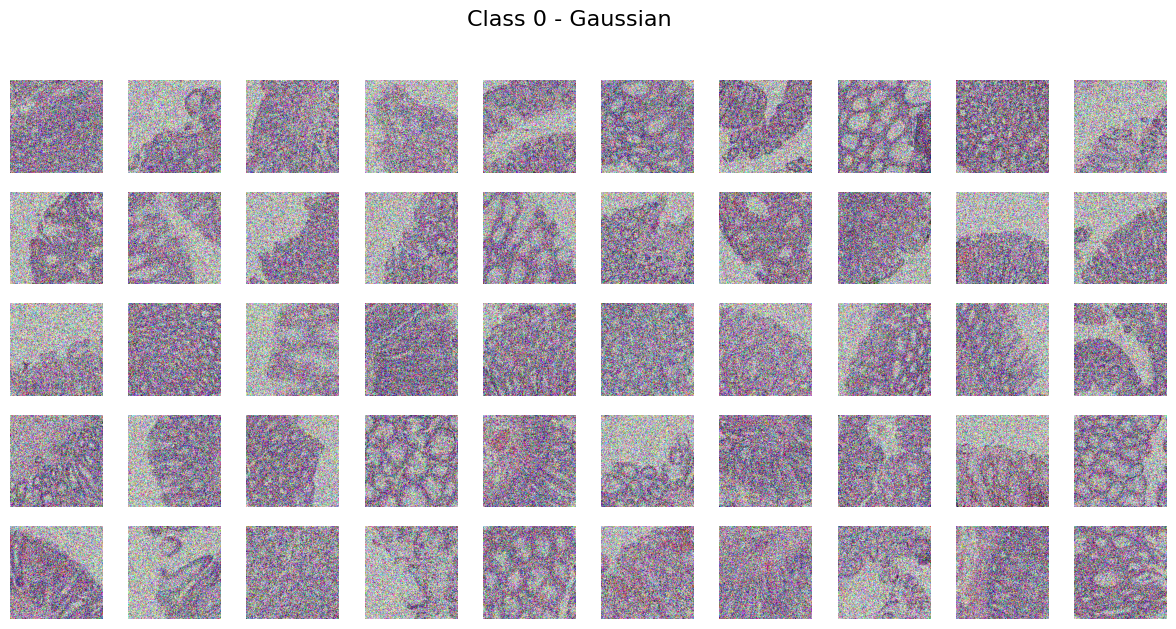

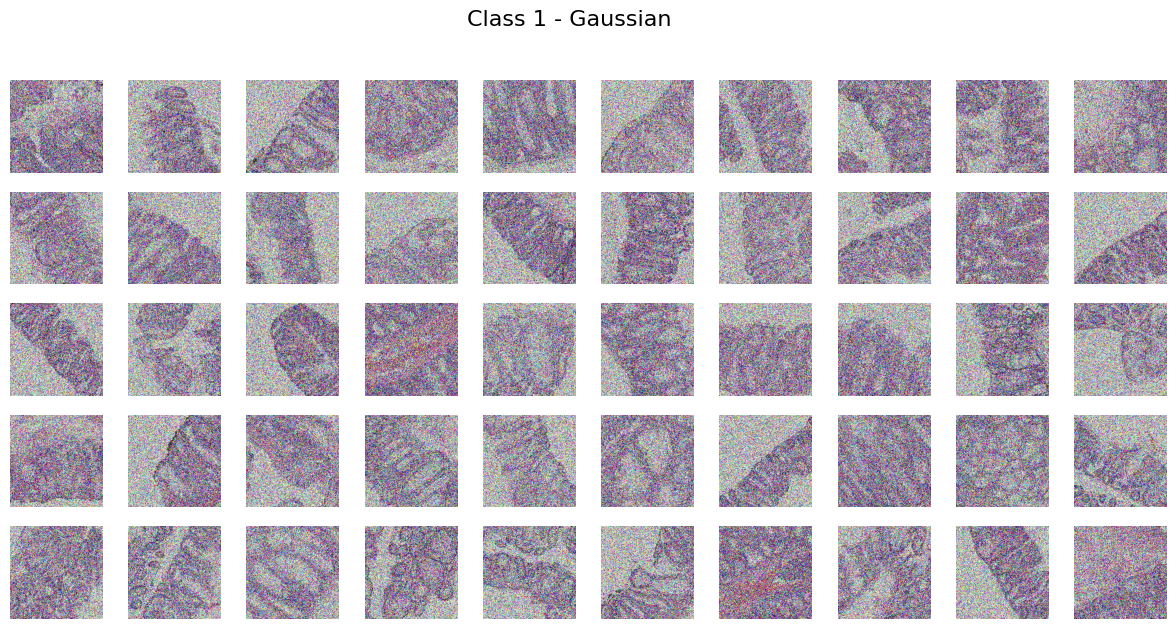

Image grids saved to task2_results/PAD_Gaussian_grid


In [23]:
img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Gaussian')

##### 2e) Train the model with condensed dataset

In [9]:
random_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
random_optimizer = SGD(random_model.parameters(), lr=0.01, momentum=0.9)

gaussian_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
gaussian_optimizer = SGD(gaussian_model.parameters(), lr=0.01, momentum=0.9)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [10]:
synthetic_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
synthetic_optimizer = SGD(synthetic_model.parameters(), lr=0.01, momentum=0.9)

synthetic_scheduler = CosineAnnealingLR(synthetic_optimizer, T_max=20)

synthetic_criterion = torch.nn.CrossEntropyLoss()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def training_model(model, optimizer, scheduler, criterion, train_loader):
    torch.cuda.empty_cache()
    for epoch in range(20):
        model.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            torch.cuda.empty_cache()
        scheduler.step()

        print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")

In [12]:
img_syn_loaded = torch.load('task2_results/PAD__synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

synthetic_dataset = TensorDataset(img_syn, labels_syn)

train_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

training_model(synthetic_model, synthetic_optimizer, synthetic_scheduler,
               synthetic_criterion, train_loader)

<ipython-input-12-8fc369861c32>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD__synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6932326006889343
Epoch [2/20], Loss: 0.6105473160743713
Epoch [3/20], Loss: 0.5474112939834594
Epoch [4/20], Loss: 0.4899586510658264
Epoch [5/20], Loss: 0.4352209520339966
Epoch [6/20], Loss: 0.37371817111968997
Epoch [7/20], Loss: 0.3207209718227386
Epoch [8/20], Loss: 0.28917009830474855
Epoch [9/20], Loss: 0.22444822251796723
Epoch [10/20], Loss: 0.18521229028701783
Epoch [11/20], Loss: 0.15790288746356965
Epoch [12/20], Loss: 0.12298051953315735
Epoch [13/20], Loss: 0.10044163346290588
Epoch [14/20], Loss: 0.08572539567947388
Epoch [15/20], Loss: 0.07666894108057022
Epoch [16/20], Loss: 0.06911796361207961
Epoch [17/20], Loss: 0.06363305777311325
Epoch [18/20], Loss: 0.060438557714223864
Epoch [19/20], Loss: 0.05886210709810257
Epoch [20/20], Loss: 0.05828015297651291


In [13]:
from torch.utils.data import TensorDataset, DataLoader

img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=64, shuffle=True)

training_model(random_model, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-13-222cbf23eb7f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.7277621603012085
Epoch [2/20], Loss: 0.6293077683448791
Epoch [3/20], Loss: 0.5812015819549561
Epoch [4/20], Loss: 0.5212393498420715
Epoch [5/20], Loss: 0.482893123626709
Epoch [6/20], Loss: 0.42568656921386716
Epoch [7/20], Loss: 0.3636916792392731
Epoch [8/20], Loss: 0.3133538603782654
Epoch [9/20], Loss: 0.26096835017204284
Epoch [10/20], Loss: 0.21092776358127593
Epoch [11/20], Loss: 0.1736295521259308
Epoch [12/20], Loss: 0.1419944280385971
Epoch [13/20], Loss: 0.12019197195768357
Epoch [14/20], Loss: 0.10311607569456101
Epoch [15/20], Loss: 0.09164761334657669
Epoch [16/20], Loss: 0.08266512185335159
Epoch [17/20], Loss: 0.07759562611579895
Epoch [18/20], Loss: 0.07419933438301086
Epoch [19/20], Loss: 0.07229889273643493
Epoch [20/20], Loss: 0.0714293909072876


In [14]:
img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=64, shuffle=True)

training_model(gaussian_model, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-14-401b36ca460b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.705660457611084
Epoch [2/20], Loss: 0.6209838843345642
Epoch [3/20], Loss: 0.5443763542175293
Epoch [4/20], Loss: 0.47547258257865904
Epoch [5/20], Loss: 0.4069499158859253
Epoch [6/20], Loss: 0.33805376052856445
Epoch [7/20], Loss: 0.27149452149868014
Epoch [8/20], Loss: 0.2101426112651825
Epoch [9/20], Loss: 0.15827323436737062
Epoch [10/20], Loss: 0.11745408892631531
Epoch [11/20], Loss: 0.09057229489088059
Epoch [12/20], Loss: 0.07113108038902283
Epoch [13/20], Loss: 0.05799913585186005
Epoch [14/20], Loss: 0.049177924394607546
Epoch [15/20], Loss: 0.04365486711263657
Epoch [16/20], Loss: 0.03982305064797401
Epoch [17/20], Loss: 0.03764982923865318
Epoch [18/20], Loss: 0.03619636699557304
Epoch [19/20], Loss: 0.035425203293561934
Epoch [20/20], Loss: 0.03509563520550728


In [15]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [16]:
evaluate_model(synthetic_model, test_loader)

Test Accuracy: 58.34%


In [18]:
evaluate_model(gaussian_model, test_loader)

Test Accuracy: 56.91%


In [17]:
evaluate_model(random_model, test_loader)

Test Accuracy: 49.74%


#### 3 Cross-Architecture Generalization

In [32]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

In [33]:
random_resnet = ResNet18(channel=3, num_classes=2)
random_optimizer = SGD(random_resnet.parameters(), lr=0.01, momentum=0.9)
random_resnet.to(device)

gaussian_resnet = ResNet18(channel=3, num_classes=2)
gaussian_optimizer = SGD(gaussian_resnet.parameters(), lr=0.01, momentum=0.9)
gaussian_resnet.to(device)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [34]:
synthetic_model = ResNet18(channel=3, num_classes=2)
synthetic_model.to(device)
synthetic_optimizer = SGD(synthetic_model.parameters(), lr=0.01, momentum=0.9)

synthetic_scheduler = CosineAnnealingLR(synthetic_optimizer, T_max=20)

synthetic_criterion = torch.nn.CrossEntropyLoss()

In [35]:
img_syn_loaded = torch.load('task2_results/PAD__synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

synthetic_dataset = TensorDataset(img_syn, labels_syn)

train_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

training_model(synthetic_model, synthetic_optimizer, synthetic_scheduler,
               synthetic_criterion, train_loader)

<ipython-input-35-8fc369861c32>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD__synthetic_dataset.pt')


Epoch [1/20], Loss: 2.363637771606445
Epoch [2/20], Loss: 88.78874053955079
Epoch [3/20], Loss: 22.71938262939453
Epoch [4/20], Loss: 47.0907421875
Epoch [5/20], Loss: 26.00038993835449
Epoch [6/20], Loss: 5.8415899658203125
Epoch [7/20], Loss: 15.24306411743164
Epoch [8/20], Loss: 7.821686553955078
Epoch [9/20], Loss: 2.950472984313965
Epoch [10/20], Loss: 4.599478502273559
Epoch [11/20], Loss: 3.1211245679855346
Epoch [12/20], Loss: 1.4637089824676515
Epoch [13/20], Loss: 1.3386138772964478
Epoch [14/20], Loss: 1.29050669670105
Epoch [15/20], Loss: 0.8388030815124512
Epoch [16/20], Loss: 0.4888938331604004
Epoch [17/20], Loss: 0.4227932929992676
Epoch [18/20], Loss: 0.39082696437835696
Epoch [19/20], Loss: 0.35714654564857484
Epoch [20/20], Loss: 0.3359580880403519


In [36]:
img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=64, shuffle=True)

training_model(random_resnet, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-36-7bd777fc3368>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 2.679343433380127
Epoch [2/20], Loss: 72.93739700317383
Epoch [3/20], Loss: 11.591845016479493
Epoch [4/20], Loss: 19.30376754760742
Epoch [5/20], Loss: 16.301278228759767
Epoch [6/20], Loss: 9.492138376235962
Epoch [7/20], Loss: 6.376056785583496
Epoch [8/20], Loss: 5.074792156219482
Epoch [9/20], Loss: 3.090129861831665
Epoch [10/20], Loss: 3.521400337219238
Epoch [11/20], Loss: 1.5377053999900818
Epoch [12/20], Loss: 1.339674301147461
Epoch [13/20], Loss: 1.4046884655952454
Epoch [14/20], Loss: 0.8525389528274536
Epoch [15/20], Loss: 0.7221668314933777
Epoch [16/20], Loss: 0.6820261144638061
Epoch [17/20], Loss: 0.5824806356430053
Epoch [18/20], Loss: 0.44136845231056215
Epoch [19/20], Loss: 0.38991293430328366
Epoch [20/20], Loss: 0.3636540222167969


In [37]:
img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=64, shuffle=True)

training_model(gaussian_resnet, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-37-56816291cd1f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('task2_results/PAD_Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 5.271409339904785
Epoch [2/20], Loss: 52.47293914794922
Epoch [3/20], Loss: 63.66279388427734
Epoch [4/20], Loss: 10.929890098571777
Epoch [5/20], Loss: 53.9443310546875
Epoch [6/20], Loss: 10.357842330932618
Epoch [7/20], Loss: 10.659589462280273
Epoch [8/20], Loss: 7.400445404052735
Epoch [9/20], Loss: 7.5729011535644535
Epoch [10/20], Loss: 4.566189832687378
Epoch [11/20], Loss: 2.4943074417114257
Epoch [12/20], Loss: 1.4499325847625733
Epoch [13/20], Loss: 0.9760878372192383
Epoch [14/20], Loss: 0.5728288447856903
Epoch [15/20], Loss: 0.058707531206309796
Epoch [16/20], Loss: 0.006189819686114788
Epoch [17/20], Loss: 0.03044808827340603
Epoch [18/20], Loss: 0.05034767471253872
Epoch [19/20], Loss: 0.041453686957247556
Epoch [20/20], Loss: 0.032229888923466204


In [38]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
evaluate_model(synthetic_model, test_loader)

Test Accuracy: 55.68%


In [40]:
evaluate_model(gaussian_resnet, test_loader)

Test Accuracy: 51.28%


In [41]:
evaluate_model(random_resnet, test_loader)

Test Accuracy: 52.30%
